In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary cache directory at C:\Users\user\AppData\Local\Temp\matplotlib-2elllqy5 because the default path (C:\Users\user\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
test_df=pd.read_csv('test.csv')
train_df=pd.read_csv('train.csv')

In [3]:
train_df.select_dtypes(exclude='object').corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

Electrical         1
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtFinType2      38
BsmtExposure      38
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
GarageCond        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

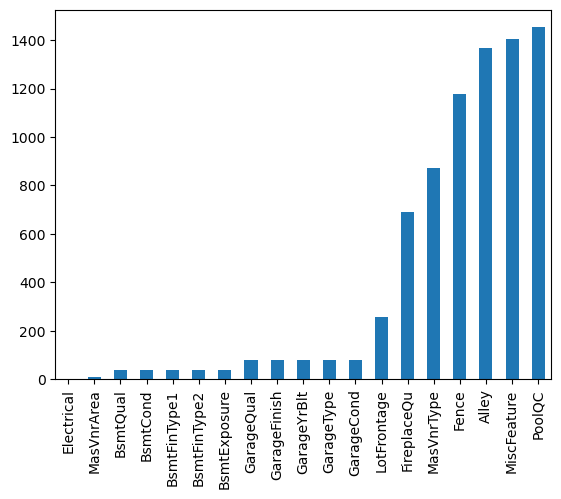

In [4]:
def misscheck(train_df):
    missing_values=train_df.isnull().sum().sort_values()
    missing_values=missing_values[missing_values>0]
    missing_values.plot(kind='bar')
    return missing_values
misscheck(train_df)

In [5]:
x=train_df.select_dtypes(include='object').isnull().sum()
x=x[x>0]
x.sort_values()

Electrical         1
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [6]:
object_tobe_filled=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']

In [7]:
train_df=train_df.drop(['MasVnrType','LotFrontage','Id'],axis=1)

In [8]:
train_df[object_tobe_filled]=train_df[object_tobe_filled].fillna("None")

In [9]:
train_df['GarageYrBlt']=train_df['GarageYrBlt'].fillna(0)

In [10]:
train_df['MasVnrArea']=train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].mean())

In [11]:
train_df=train_df.dropna(subset=['Electrical'])

In [12]:
def remove_outliers_iqr(df, columns, threshold=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# List of numerical columns to check for outliers
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Apply outlier removal
train_df = remove_outliers_iqr(train_df, num_cols)

print(f"Shape after: {train_df.shape}")

Shape after: (532, 78)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

onehot_features = [
    'MSZoning', 'Street', 'Alley',  'LotConfig', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'Electrical','HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'CentralAir',
    'MiscFeature', 'SaleType', 'SaleCondition'
]

label_features = [
    'LotShape', 'LandContour','Utilities','LandSlope',  'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
    'KitchenQual',  'GarageType',
    'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'
]

num_features = [ 'MSSubClass','OverallQual','OverallCond','LotArea', 'YearBuilt', 'YearRemodAdd', 
                'MasVnrArea', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'
]

numeric_transformer = StandardScaler()

onehot_transformer = OneHotEncoder(handle_unknown='ignore')

label_transformer = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, onehot_features),
    ('label', label_transformer, label_features),
    ('numeric',numeric_transformer, num_features)
])

In [14]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np

# Prepare data
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"]

# Define pipeline without numeric scaling
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply all transformations
    ('model', xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42))
])

# Cross-validation on the full dataset
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert negative MAE to positive values
cv_mae = -np.mean(cv_scores)

print(f"Cross-validated MAE: {cv_mae:.2f}")

Cross-validated MAE: 11994.77


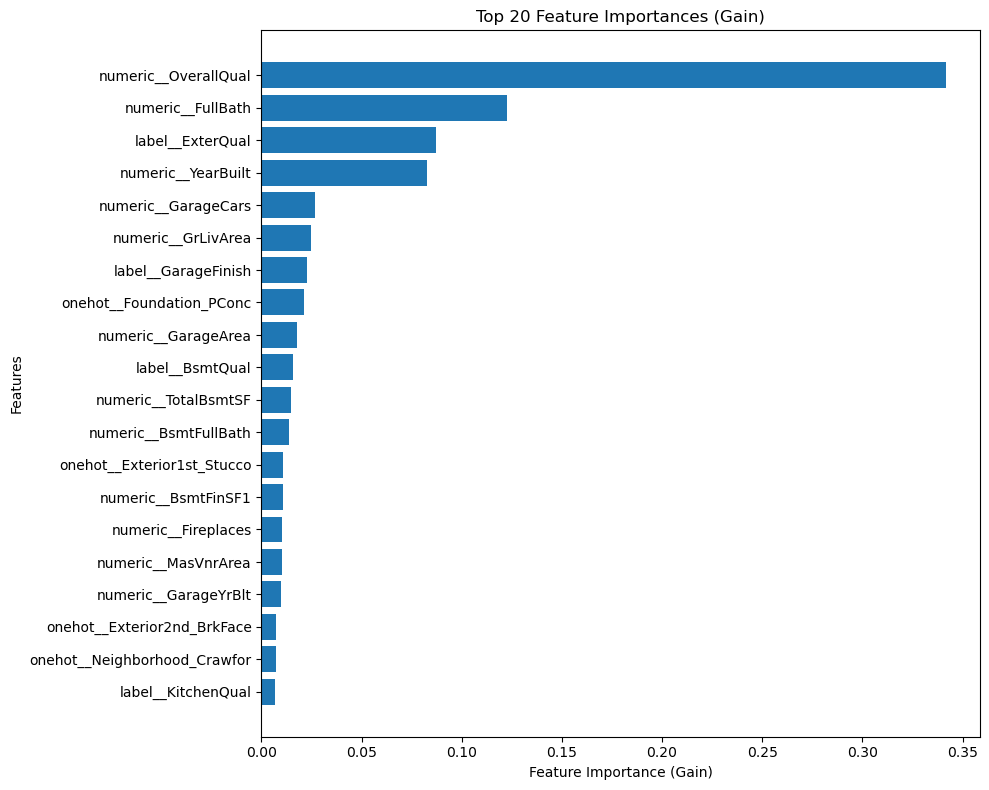

In [15]:
# Train model on full dataset
model_pipeline.fit(X, y)

# Get transformed feature names
preprocessor = model_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Extract feature importances
booster = model_pipeline.named_steps['model']
importances = booster.feature_importances_

# Sort and select top N features
N = 20  # Choose the number of top features to display (adjust as needed)

sorted_idx = importances.argsort()[::-1]
top_N_idx = sorted_idx[:N]

top_N_importances = importances[top_N_idx]
top_N_feature_names = feature_names[top_N_idx] #Use the transformed names

# Plot the top N features
plt.figure(figsize=(10, 8))
plt.barh(top_N_feature_names, top_N_importances)
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.title(f"Top {N} Feature Importances (Gain)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()